# Data structures accepted by seaborn

作为一个数据可视化库，seaborn需要您为它提供数据。本章解释了完成该任务的各种方法。seaborn支持几种不同的数据集格式，大多数函数接受来自pandas或numpy库的对象以及列表和字典等内置Python类型表示的数据。理解与这些不同选项相关联的使用模式将帮助您为几乎任何数据集快速创建有用的可视化。

> **Note**
> 截至目前(v0.11.0)，只有seaborn中的一部分模块(即 `relation` 模块和 `distribution` 模块)支持这里涉及的所有选项。其他模块提供了很多相同的灵活性，但也有一些例外(例如，`catplot()` 和 `lmplot()` 仅限于带有命名变量的长格式数据)。data-ingest 代码将在接下来的几个发布周期中标准化，但在此之前，如果每个函数没有对数据集执行您所期望的操作，请注意每个函数的特定文档。

## Long-form vs. wide-form data

在 seaborn 上，大多数绘图函数都是面向数据矢量的。当绘制x和y的坐标时，每个变量都应该是一个向量。Seaborn接受以表格形式组织多个向量的数据集。long-forn 和 width-form 数据表之间有一个基本的区别，而seaborn将以不同的方式对待它们。

### Long-form data

long-form 数据表具有以下特征：

- 每个 variable 是一列
- 每个 observation 是一行

作为一个简单的例子，考虑航班数据集，它记录了从1949年到1960年每个月乘坐航班的乘客数量。这个数据集有三个 variable (year、month 和 number of passengers):

In [1]:
import seaborn as sns

In [3]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


对于 long-form 数据，通过显式地将表中的列分配给一个 variable，表中的列在图中被赋予了角色。例如，绘制出每年乘客数量的月线图，像这样:

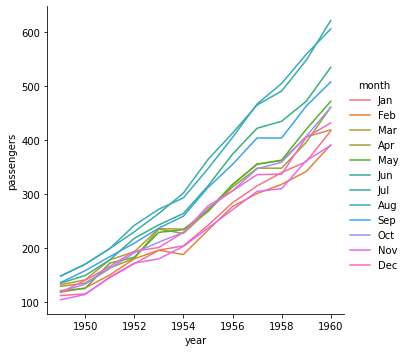

In [4]:
sns.relplot(data=flights, x="year", y="passengers", hue="month", kind="line")

long-form 数据的优势在于，它很适合这种 explicit specification 的 plot。它可以容纳任意复杂的数据集，只要 variable 和 observations 可以明确定义。但是这种格式需要一些时间来适应，因为它通常不是人们头脑中的数据模型。

### Wide-form data


对于简单的数据集，用 spreadsheet 的方式看待数据通常更直观, 其列和行包含不同 level 的 variable。例如，我们可以将 flights 数据集转换为一个 wide-form 形式，方法是对其进行 pivoting，使每一列具有多年来每个月的时间序列：

In [5]:
flights_wide = flights.pivot(index="year", columns="month", values="passengers")
flights_wide.head()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201


这里我们有三个相同的变量，但它们的组织方式不同。这个数据集中的变量链接到表的维度，而不是指定的字段。每个 observation 都是由表中单元格的值和该单元格相对于行和列索引的坐标定义的。

对于 long-form 数据，我们可以通过名称访问数据集中的变量。wide-form 数据并非如此。然而，由于表的维度与数据集中的变量之间存在明确的关联，seaborn能够在图中为这些变量分配角色。

> **Note**
> 当x和y都没有赋值时，Seaborn将data的参数视为 width-form。

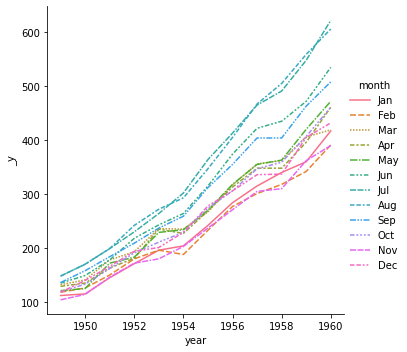

In [8]:
sns.relplot(data=flights_wide, kind="line")

这个图看起来和之前的很相似。Seaborn 将 dataframe 的索引赋值给 x，将 dataframe 的值赋值给 y，并为每个月画了一条单独的线。然而，这两个 plot 有一个显著的不同。当数据集通过pivot操作将其从 long-form 转换为 wide-form 时，有关 values 含义的信息就丢失了。因此，没有 y 轴标签。(这里的线条也有破折号，因为`relplot()` 已经将列变量映射到 `hue` 和 `style` 语义，以便 plot 更容易访问。我们没有在 long-form 的情况下这样做，但我们可以通过设置 `style="month"`。

到目前为止，我们在使用 wide-form 数据时输入的内容要少得多，并且绘制了几乎相同的图表。这似乎更容易!但是 long-form 数据的一个很大的优点是，一旦有了正确格式的数据，就不再需要考虑它的结构了。您可以通过只考虑其中包含的变量来设计绘图。例如，要画出代表 monthly time series for each year 的线，只需重新分配变量:

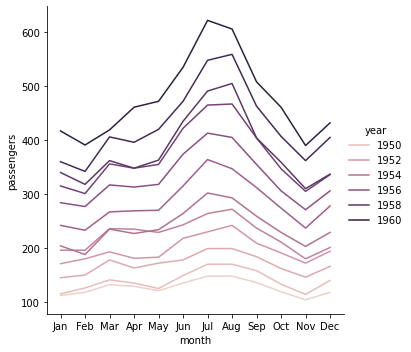

In [9]:
sns.relplot(data=flights, x="month", y="passengers", hue="year", kind="line")

要对 wide-form 数据集实现相同的重映射，我们需要 transpose 表

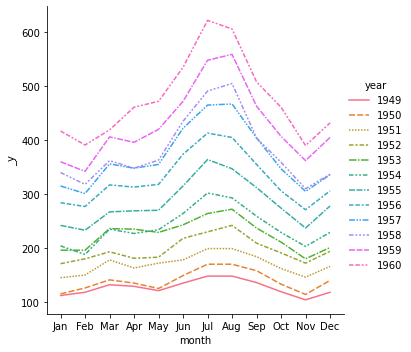

In [11]:
sns.relplot(data=flights_wide.transpose(), kind="line")

(这个例子还说明了另一个问题，即seaborn目前认为 wide-form 数据集中的列变量无论其数据类型如何都是 categorical，而由于 long-form 变量是 numeric，所以它被分配一个quantitative color palette 和 legend。这种情况将来可能会改变)

缺少显式的变量赋值还意味着每个 plot 类型需要在 wide-form 数据的维度和 plot 中的角色之间定义固定的映射。由于自然映射可能在不同的plot类型中有所不同，所以当使用 wide-form 数据时，结果是不可预测的。例如，`categorical` plots 将表的列维度分配给 x，然后跨行聚合(忽略索引)

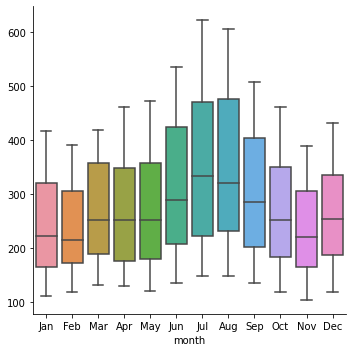

In [12]:
sns.catplot(data=flights_wide, kind="box")

当使用pandas来表示 wide-form 数据时，只有几个变量(不超过三个)。这是因为seaborn没有使用 multi-index 信息，而这正是panda在表格格式中表示额外变量的方式。`xarray` 项目提供了标记的 n维数组对象，可以将 wide-form 数据推广到更高维度。目前，seaborn不直接支持来自xarray的对象，但它们可以使用 `to_pandas` 方法转换成一个 long-form 的 `pandas.DataFrame` ，然后像其他 long-form 数据集一样在 seaborn 上绘制。

总之，我们可以把 long-form 和 wide-form 的数据集想象成这样:

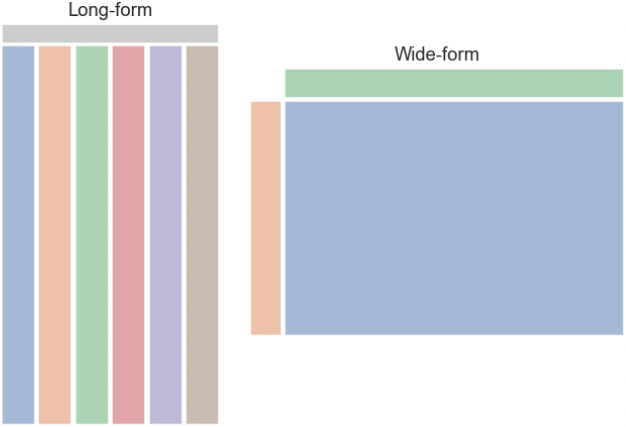

### Messy data

许多数据集无法使用 long-form 或 wide-form 规则清楚地解释。如果很明显的 long-form 或 wide-form 数据集是 "tidy"，我们可能会说这些更 ambiguous 的数据集是 “messy”。在 messy 数据集中，变量既不是由表的键唯一定义的，也不是由表的维唯一定义的。这通常发生在 repeated-measures 数据中，在 repeated-measures 数据中，很自然地组织一个表，使每一行对应于数据收集的单元。考虑这个来自心理学实验的简单数据集，在这个实验中，20名受试者在注意力分散或集中的情况下完成了一项记忆任务，研究字谜:

In [13]:
anagrams = sns.load_dataset("anagrams")
anagrams

,subidr,attnr,num1,num2,num3
0,1,divided,2,4.0,7
1,2,divided,3,4.0,5
2,3,divided,3,5.0,6
3,4,divided,5,7.0,5
4,5,divided,4,5.0,8
5,6,divided,5,5.0,6
6,7,divided,5,4.5,6
7,8,divided,5,7.0,8
8,9,divided,2,3.0,7
9,10,divided,6,5.0,6


attention variable 存在于  between-subjects，但也存在于 within-subjects:字谜的可能解的数量，从1到3不等。相关的度量是记忆表现的分数。这两个变量(number和score)在几个列中联合编码。因此，整个数据集既不是明显的 long-form，也不是明显的 wide-form。

我们如何告诉seaborn将平均分数作为注意力和解决方案数量的函数来绘制?我们首先需要将数据强制转换为两个结构中的一个。让我们将其转换为一个 tidy long-form table，这样每个 variable 就是一个列，而每一行就是一个 observation。我们可以使用方法 `pandas.DataFrame.melt()` 来完成这个任务:

In [16]:
anagrams_long = anagrams.melt(id_vars=["subidr", "attnr"], var_name="solutions", value_name="score")
anagrams_long

,subidr,attnr,solutions,score
0,1,divided,num1,2.0
1,2,divided,num1,3.0
2,3,divided,num1,3.0
3,4,divided,num1,5.0
4,5,divided,num1,4.0
5,6,divided,num1,5.0
6,7,divided,num1,5.0
7,8,divided,num1,5.0
8,9,divided,num1,2.0
9,10,divided,num1,6.0


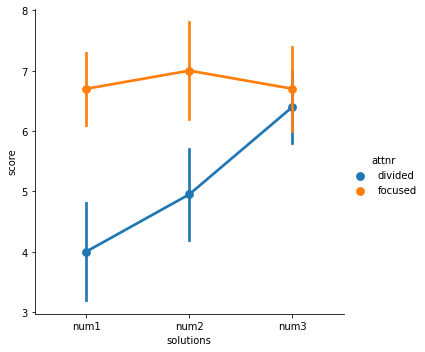

In [17]:
sns.catplot(data=anagrams_long, x="solutions", y="score", hue="attnr", kind="point")

### Further reading and take-home points

关于表格数据结构的更详细的讨论，您可以阅读 Hadley Whickham 的Tidy data 论文。请注意，seaborn使用的一组概念与本文中定义的略有不同。虽然本文将 tidy 与 long-form 结构联系在一起，但我们已经区分了 tidy wide-form 数据和 messy 数据之间的区别，前者在数据集中的变量和表的维度之间有一个清晰的映射，后者不存在这样的映射。

long-form 结构优势明显。它允许您通过显式地将数据集中的变量分配给 plot 中的角色来创建图形，您可以使用三个以上的变量来实现这一点。如果可能的话，在着手进行认真的分析时，试着用 long-form 的结构表示数据。seaborn文档中的大多数示例都将使用 long-form 数据。

## Options for visualizing long-form data

虽然 long-form 数据有一个精确的定义，但就如何跨内存中的数据结构组织它而言，seaborn相当灵活。

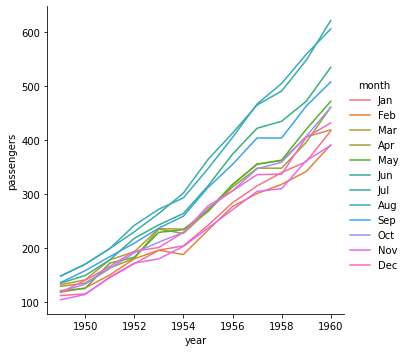

In [18]:
flights_dict = flights.to_dict()
sns.relplot(data=flights_dict, x="year", y="passengers", hue="month", kind="line")

许多 padnas 操作，例如 group-by 的 split-apply-combine 操作，将产生一个 dataframe，其中信息已从输入 dataframe 的列移动到输出的索引。只要保留名称，您仍然可以正常引用数据:

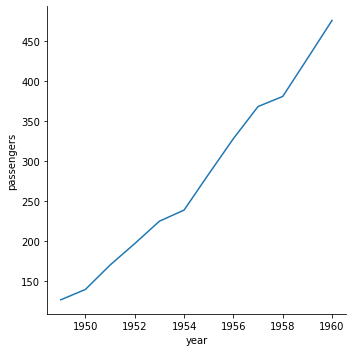

In [21]:
flights_avg = flights.groupby("year").mean()
sns.relplot(data=flights_avg, x="year", y="passengers", kind="line")

此外，还可以将数据向量直接作为参数传递给 `x、y` 和其他绘图变量。如果这些向量是 pandas 对象，则 `name` 属性将用于标记 plot:

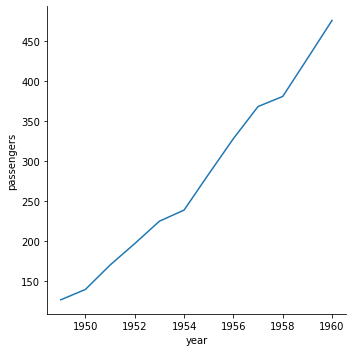

In [22]:
year = flights_avg.index
passengers = flights_avg["passengers"]
sns.relplot(x=year, y=passengers, kind="line")

Numpy数组和其他实现Python序列接口的对象也可以工作，但是如果它们没有名称，那么不作进一步调整，就不能提供足够的信息

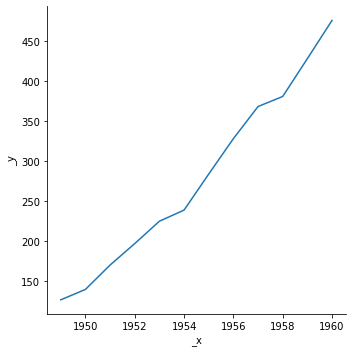

In [23]:
sns.relplot(x=year.to_numpy(), y=passengers.to_list(), kind="line")

## Options for visualizing wide-form data

用于传递 wide-form 数据的选项甚至更加灵活。与 long-form 数据一样， pandas 对象更可取，因为可以使用名称(在某些情况下，还可以使用索引)信息。但本质上，任何可以被视为单个向量或向量集合的格式都可以传递给数据，并且通常可以构造有效的 plot。

我们上面看到的例子使用了一个矩形的 `pandas.DataFrame`，可以将其视为其列的集合。一个字典或 pandas 对象列表也可以工作，但我们将失去轴标签:

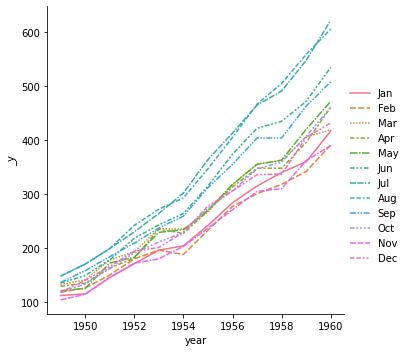

In [24]:
flights_wide_list = [col for _, col in flights_wide.items()]
sns.relplot(data=flights_wide_list, kind="line")

集合中的向量不需要有相同的长度。如果它们有索引，将使用它来对齐它们:

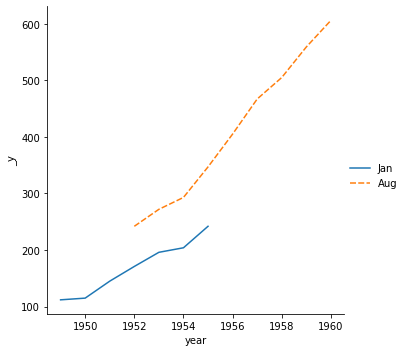

In [25]:
two_series = [flights_wide.loc[:1955, "Jan"], flights_wide.loc[1952:, "Aug"]]
sns.relplot(data=two_series, kind="line")

而序数索引将用于numpy数组或简单的Python序列

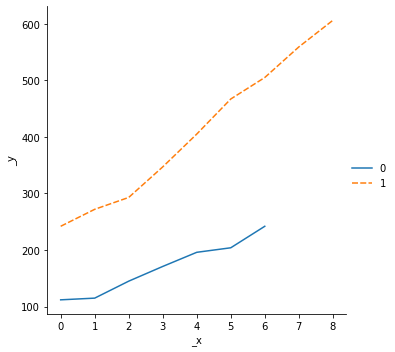

In [26]:
two_arrays = [s.to_numpy() for s in two_series]
sns.relplot(data=two_arrays, kind="line")

但是包含这些向量的字典至少会使用键

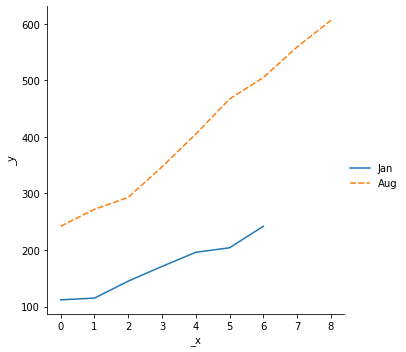

In [27]:
two_arrays_dict = {s.name: s.to_numpy() for s in two_series}
sns.relplot(data=two_arrays_dict, kind="line")

矩形numpy数组被视为没有索引信息的 dataframe ，因此它们被视为列向量的集合。注意，这与numpy索引操作的工作方式不同，在numpy中，单个索引器将访问一行。但这与 pandas 如何将数组转换为 dataframe 或 matplotlib 如何绘制它是一致的:

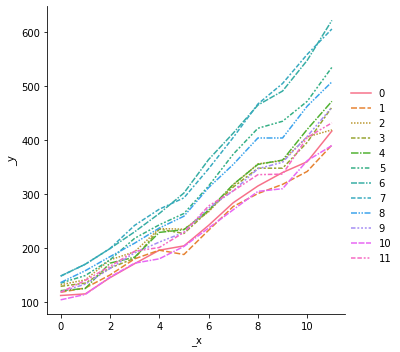

In [28]:
flights_array = flights_wide.to_numpy()
sns.relplot(data=flights_array, kind="line")